In [1]:
from crikit import *
import jax 
from jax import numpy as jnp
import numpy as np
jax.config.enable_omnistaging()
import matplotlib.pyplot as plt
from matplotlib import cm as plt_cm
import ufl
import pyadjoint

Now we can define the domain on which we solve the problem, as well as the physics itself. For a detailed explanation of the linear version of said physics, as well as the Taylor-Hood discretization we're using, see https://fenicsproject.org/olddocs/dolfin/2016.2.0/python/demo/documented/stokes-taylor-hood/python/documentation.html. The introduction of the parameter $p$ (distinct from the pressure field, which we'll call $\pi$) turns the linear Stokes equations into the nonlinear form we're using here.

In [2]:
N = 10
dims = 2
mesh = UnitSquareMesh(N, N)
V = VectorElement("CG", mesh.ufl_cell(), 2)
Q = FiniteElement("CG", mesh.ufl_cell(), 1)
W = FunctionSpace(mesh, V * Q)

In [3]:
rho = 1.0
g = 9.8 # m / s ^2
alpha = 0.15 #incline in radians
#force
force = Constant((rho * g * cos(alpha), -rho * g * sin(alpha)), name='force')


def apply_robin_bc(F, u, v, bc):
    a, b, j, ds = bc
    return F + inner(v, (a * u - j))/b * ds

robin_a = 1
robin_b = 0.5
cmap = plt_cm.get_cmap('magma')
inflow = Expression(("x[1]*(1-x[1])/2", "0"), degree=2)
noslip = ufl.zero(dims)
def side_boundary(x, on_boundary):
    return on_boundary and (near(x[1], 1, 1e-6) or near(x[1], 0, 1e-6))

def inflow_boundary(x, on_boundary):
    return on_boundary and near(x[0], 0, 1e-6)

def outflow_boundary(x, on_boundary):
    return on_boundary and near(x[0], 1, 1.0e-6)

class OutflowBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return outflow_boundary(x, on_boundary)

In [4]:
# a class that will take observations on a specified SubDomain by zeroing the vector
# everywhere else
observer = SubdomainObserver(mesh, OutflowBoundary())
class InflowBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return inflow_boundary(x, on_boundary)
        
class SideBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return side_boundary(x, on_boundary)
        
markers = MeshFunction("size_t", mesh, mesh.topology().dim() - 1, 0)
InflowBoundary().mark(markers, 1)
SideBoundary().mark(markers, 2)
dleft = ds(1, domain=mesh, subdomain_data=markers)
dside = ds(2, domain=mesh, subdomain_data=markers)
robin_a = Constant(robin_a)
robin_b = Constant(robin_b)
robin_bcs = [(robin_a, robin_b, inflow, dleft), (robin_a, robin_b, noslip, dside)]

#set parameters for crikit.covering -- IMPORTANT!! DO NOT OMIT!! Otherwise, 
#we won't be able to automatically generate a covering from the UFLExprSpace defined 
#by sym(grad(u)) to a space of JAX arrays. We need 3rd order quadrature because of the 
#4th degree terms on the diagonal of the mass matrix
set_default_covering_params(domain=mesh.ufl_domain(), quad_params={'quadrature_degree' : 3})

The true CR that we'll be trying to learn is 

$$
\sigma = (\mathrm{tr}(F\cdot F )+ \epsilon ^ 2)^{( p - 2) / 2} F
$$

where $F = \frac{\nabla\mathbf{u} + \nabla\mathbf{u}^T}{2}$ and $\epsilon$ is a regularization constant. This is known as a _p-laplacian_ CR.

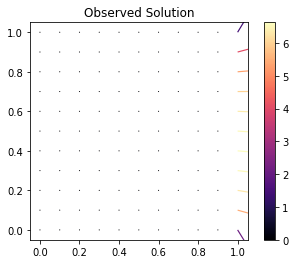

In [5]:
#true value of a and p
a = Constant(1.0, name='a')
p = Constant(1.2, name='p')
#regularization 
eps2 = 0.01
def true_cr(eps):
    scalar_invt = tr(dot(eps, eps))
    mu = a * (scalar_invt + eps2) ** ((p - 2) / 2)
    return mu * eps
with record_tape_block(name='Generating Data'):
    #define the problem
    w_true = Function(W)
    u, pi = split(w_true)
    sigma = true_cr(sym(grad(u)))
    w_test = TestFunction(W)
    v, tau = split(w_test)
    lhs = (inner(sigma, grad(v)) * dx
               - inner(div(v), pi) * dx
               - inner(div(u), tau) * dx
            )
    rhs = inner(force, v) * dx
    F = lhs - rhs
    for bc in robin_bcs:
        F = apply_robin_bc(F, u, v, bc)
        
    #applied BCs already, no need to use any more here
    solve(F == 0, w_true, [])
    
with stop_annotating():
    plt.figure()
    u, p = w_true.split()
    plt.colorbar(plot(u, cmap=cmap))
    plt.title(f"Solution with true CR, with a = 1.0, p = 1.2")
    plt.show()
    plt.figure()
    plt.colorbar(plot(observer(w_true).split()[0], cmap=cmap))
    plt.title("Observed Solution")

Now we can define our JAX-based CRs, which we'll use to learn MAP estimates for the parameters $\theta$, a two-component vector. The first component is a scale component called $a$, and the second component is $p$. 

Defining a JAX CR is very easy, and you have two options as to how to do it. Regardless of which approach you take, you will have to define your inputs as a list or tuple of `crikit.invariants.TensorType` instances, as well as a `TensorType` representing the output of your CR function. The first approach is to write a function that represents your CR in the form

$$
\sigma = \sum\limits_i \phi_i(I_S(A, B, \ldots ); \theta) F_i(A, B, \ldots )
$$

where $I_S(A, B, \ldots )$ are scalar values that are invariant under symmetry transformations of the inputs $A, B, \ldots$ (i.e. under the orthogonal or special orthogonal group over all the inputs) called <em>scalar invariants</em>, $F_i$ are so-called <em>form invariants</em>, tensors with the same `TensorType` representation as $\sigma$ that are themselves equivariant (not <em>invariant</em>, despite their name!) under the same symmetry transformations, and $\phi_i$ are scalar-valued functions. $\theta$ are the parameters passed to the `CR` constructor. The `crikit.invariants` module computes the $I_S$ and $F_i$ functions for you; all you need to provide is a function to compute the $\phi_i$, and provide them in a one-dimensional JAX array. If your material is not isotropic like the one modeled here is, you should pass the structural tensor representing that anisotropy as one of your inputs, and add a corresponding `TensorType` describing that structural tensor as one of your input types. If that tensor is the Levi-Civita tensor, use a `LeviCivitaType` to represent it, but don't pass in a concrete (i.e. array or `Function`) representation to the `CR` when evaluating it or using `assemble_with_cr()`; the `CR` will account for its presence when determining the invariants.


The other approach to building a `CR` is to represent it with a <em>strain-energy density</em>,

$$
W = \phi(I_S(A, B, \ldots); \theta)
$$

where $\phi$ is a scalar-valued function of the scalar invariants and parameters. The `CR` will then use JAX to differentiate the strain-energy density with respect to the first input, which should be the (symmetric) strain tensor to get a stress tensor $\sigma$. If you do this, be sure to pass `strain_energy=True` to the `CR` constructor, because it is also possible to construct a scalar-valued `CR` which will not differentiate the function you pass it.

The value $\mathrm{tr}(F\cdot F)$ is the second scalar invariant, which makes writing the JAX versions of the true CR easy:

In [6]:
def learned_cr(invts, theta):
    a, p = theta
    return jnp.array([0, a * (invts[1] + eps2) ** ((p - 2) / 2)])

#initial guess
theta = array([0.9, 1.4])

cr = CR(TensorType.make_symmetric(2, dims, 'sigma'),
        [TensorType.make_symmetric(2, dims, 'eps')],
       learned_cr,
       params=[theta])

In [7]:
cr.invariant_descriptions()

Initial loss: ndarray(DeviceArray(0.01046476, dtype=float64))


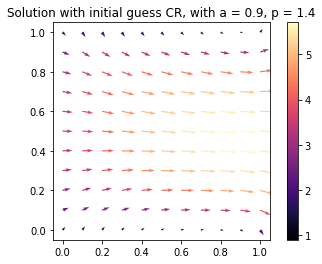

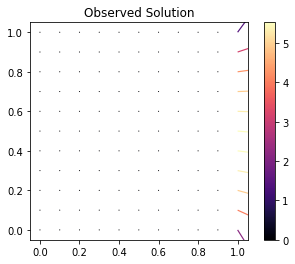

In [8]:
#if you find that the optimization loop is too expensive for your taste, you can
#replace this upcoming line with w = w_true, since this is just the initial guess of the 
#solution to the PDE defined by the learned CR
with record_tape_block(name='JAX CR Solve'):
    w = Function(W)
    cr_target_shape = tuple(i for i in cr.target.shape() if i != -1)
    #creates an object that can act as a standin for the output of the CR; 
    #the actual CR will be evaluated by assemble_with_cr()
    sigma, = create_ufl_standins((cr_target_shape,))
    u, pi = split(w)
    w_test = TestFunction(W)
    v, tau = split(w_test)
    lhs = (inner(sigma, grad(v)) * dx
               - inner(div(v), pi) * dx
               - inner(div(u), tau) * dx
            )
    rhs = inner(force, v) * dx
    F = lhs - rhs
    for bc in robin_bcs:
        F = apply_robin_bc(F, u, v, bc)
        
    with push_tape():
        #create a new sub-tape to do the solve
        resid = Function(W)
        #kwargs (here, 'tensor' and 'quad_params') are passed on to crikit.fe_adjoint.assemble
        assemble_with_cr(F, cr, sym(grad(u)), sigma, tensor=resid, quad_params={'quadrature_degree' : 3})
        wcontrol = Control(w)
        res_rf = ReducedFunction(resid, wcontrol)
    red_eq = ReducedEquation(res_rf, [], homogenize_bcs([]))
    #the problem is small, so let's assemble the Jacobian and pass it to the SNES so we can
    #use a direct solver
    solver = SNESSolver(red_eq, {'jmat_type' : 'assembled'})
    w = solver.solve(wcontrol)
    
jax_seed = 0
#sliced quadratic Wasserstein distance
loss_func = SlicedWassersteinDistance(W, 500, jax.random.PRNGKey(jax_seed), p=2)
err = loss_func(observer(w), observer(w_true))
print("Initial loss:", err)
with stop_annotating():
    plt.figure()
    u, p = w.split()
    plt.colorbar(plot(u, cmap=cmap))
    plt.title(f"Solution with initial guess CR, with a = {theta[0]}, p = {theta[1]}")
    plt.show()
    plt.figure()
    plt.colorbar(plot(observer(w).split()[0], cmap=cmap))
    plt.title("Observed Solution")

In [9]:
Jhat = ReducedFunctional(err, Control(theta))
#a function that's called before every evaluation of Jhat
Jhat.eval_cb_pre = lambda x: print('theta:', x)
#bounds to make sure the PDE is always physical; pyadjoint currently has a bug 
#that makes it so that we need to wrap our bounds in lists like this:
bounds = [[np.array([0.01, 1.01])], [np.array([2., 2.])]]
#make sure the derivative is correct
assert pyadjoint.taylor_test(Jhat, theta, 0.5* array(np.random.randn(*theta.shape))) >= 1.8
optimal_theta = minimize(Jhat, method='L-BFGS-B', bounds=bounds)
print('Optimal theta estimate:', optimal_theta)

theta: ndarray(DeviceArray([0.9, 1.4], dtype=float64))
Running Taylor test
theta: ndarray(ndarray(DeviceArray([0.8945214 , 1.40645628], dtype=float64)))
theta: ndarray(ndarray(DeviceArray([0.8972607 , 1.40322814], dtype=float64)))
theta: ndarray(ndarray(DeviceArray([0.89863035, 1.40161407], dtype=float64)))
theta: ndarray(ndarray(DeviceArray([0.89931517, 1.40080703], dtype=float64)))
Computed residuals: [DeviceArray(1.84730958e-06, dtype=float64), DeviceArray(4.54937616e-07, dtype=float64), DeviceArray(1.1221255e-07, dtype=float64), DeviceArray(2.81903058e-08, dtype=float64)]
Computed convergence rates: [2.021685030396981, 2.0194346845667854, 1.9929630091815402]
theta: ndarray(DeviceArray([0.89931517, 1.40080703], dtype=float64))
theta: ndarray(DeviceArray([0.86697727, 1.34611911], dtype=float64))
theta: ndarray(DeviceArray([0.83344134, 1.28494353], dtype=float64))
theta: ndarray(DeviceArray([0.84431087, 1.29342129], dtype=float64))
theta: ndarray(DeviceArray([0.83735071, 1.28799267], 